In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Bouts
from megabouts.utils.utils_bouts import NameCat

from megabouts.pipeline.full_tracking_fast import PipelineFullTrackingFast,PipelineFullTrackingFast_Result
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentationClassification

from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle

# Load Data


In [3]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')
#df = df.iloc[:700*90,:]


x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)
tail_angle[tail_angle<-10]=np.nan # Set Nan when tail angle out of range:


# Run Pipeline:

In [4]:
cfg_tail_preprocess = ConfigTailPreprocess(fps=700,num_pcs=4,limit_na_ms=100,
                                           baseline_method='slow',
                                           baseline_params={'fps':700})

cfg_traj_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)

cfg_segment_classify = ConfigTailSegmentationClassification(fps=700,
                                                            min_code_height=1,min_spike_dist_ms=200,
                                                            margin_before_peak_ms=32,
                                                            bout_duration_ms=200,
                                                            augment_max_delay_ms=24,
                                                            augment_step_delay_ms=2,
                                                            feature_weight= np.array([1.6]*7+[0.5,0.4,1]),
                                                            N_kNN=3,
                                                            filename_template='kNN_Training_Dataset.npz')#'TemplateFromkNN_Tu.npz')

pipeline = PipelineFullTrackingFast(cfg_tail_preprocess,
                                cfg_traj_preprocess,
                                cfg_segment_classify,
                                load_training=True)

# Tuning Smoothing fc

In [52]:
tail_angle_clean,baseline = pipeline.preprocess_tail(tail_angle)

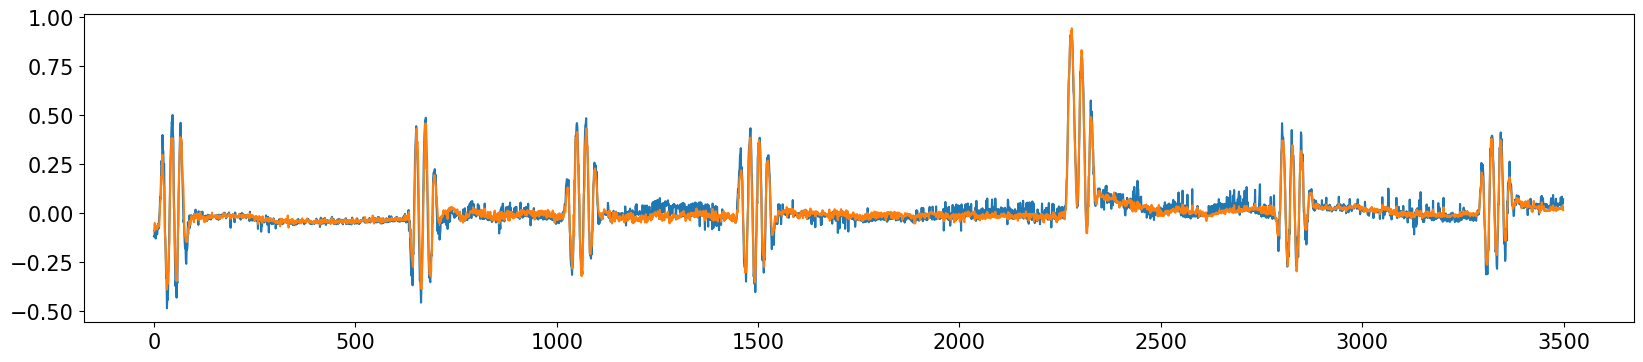

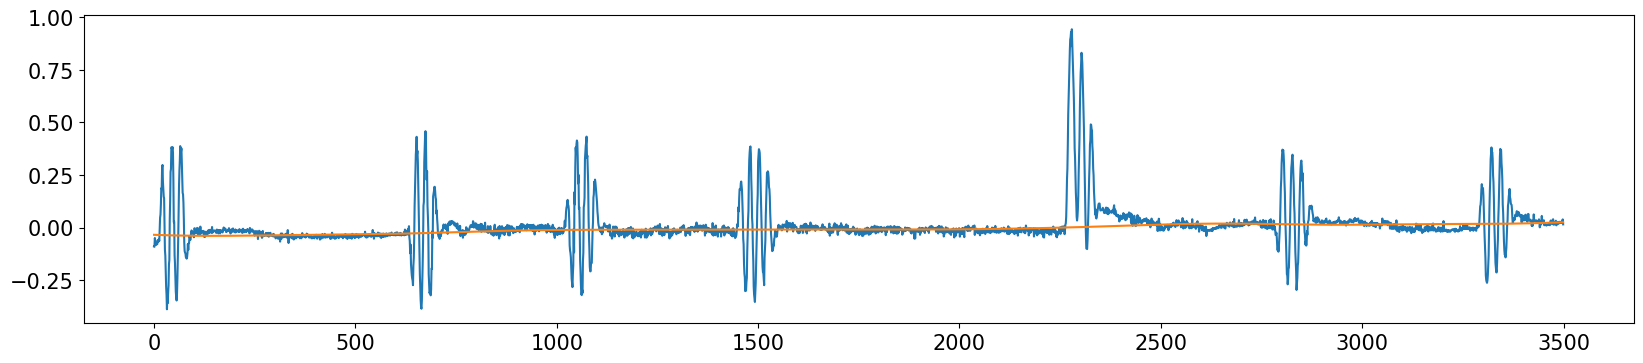

In [53]:
Duration = 700*5
IdSt = np.random.randint(tail_angle.shape[0]-Duration)

plt.figure(figsize=(20,4))
plt.plot(tail_angle[IdSt:IdSt+Duration,6])
plt.plot(tail_angle_clean[IdSt:IdSt+Duration,6])
plt.show()

plt.figure(figsize=(20,4))
plt.plot(tail_angle_clean[IdSt:IdSt+Duration,6])
plt.plot(baseline[IdSt:IdSt+Duration,6])
plt.show()

In [5]:
res = pipeline.run(tail_angle,x,y,body_angle)

In [10]:
mobility = res.mobility
tail_angle_detrend = res.tracking_data_clean.tail_angle

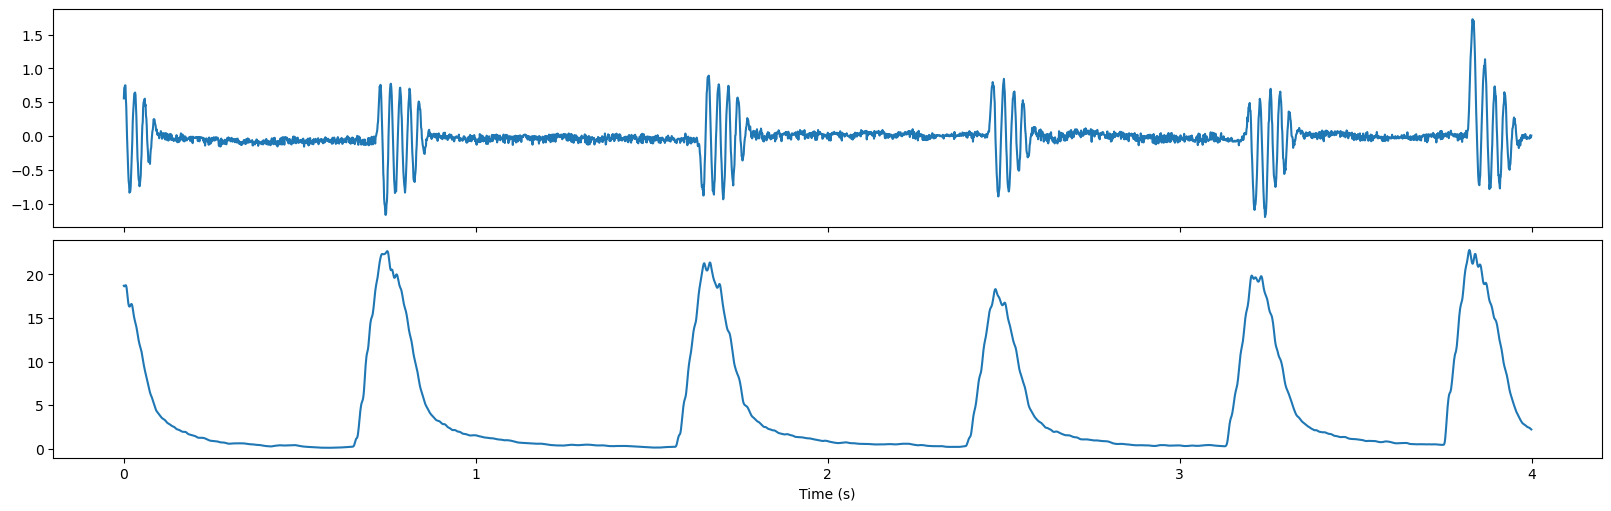

In [11]:
Duration = 700*5
IdSt= np.random.randint(mobility.shape[0]-Duration)

fig, (ax) = plt.subplots(2,1,figsize=(16,5), sharex=True,constrained_layout=True)
ax[0].plot(tail_angle[IdSt:IdSt+Duration,6])
ax[1].plot(mobility[IdSt:IdSt+Duration])

ax[1].set_xlabel('Time (s)')
ax[1].set_xticks(np.linspace(0,Duration,5))
ax[1].set_xticklabels(np.arange(0,5))
plt.show()

In [12]:
templates_labels = pipeline.knn_training_dataset_augmented.labels
tail_and_traj_array = res.tail_and_traj_array
bout_category = res.classification.bout_category

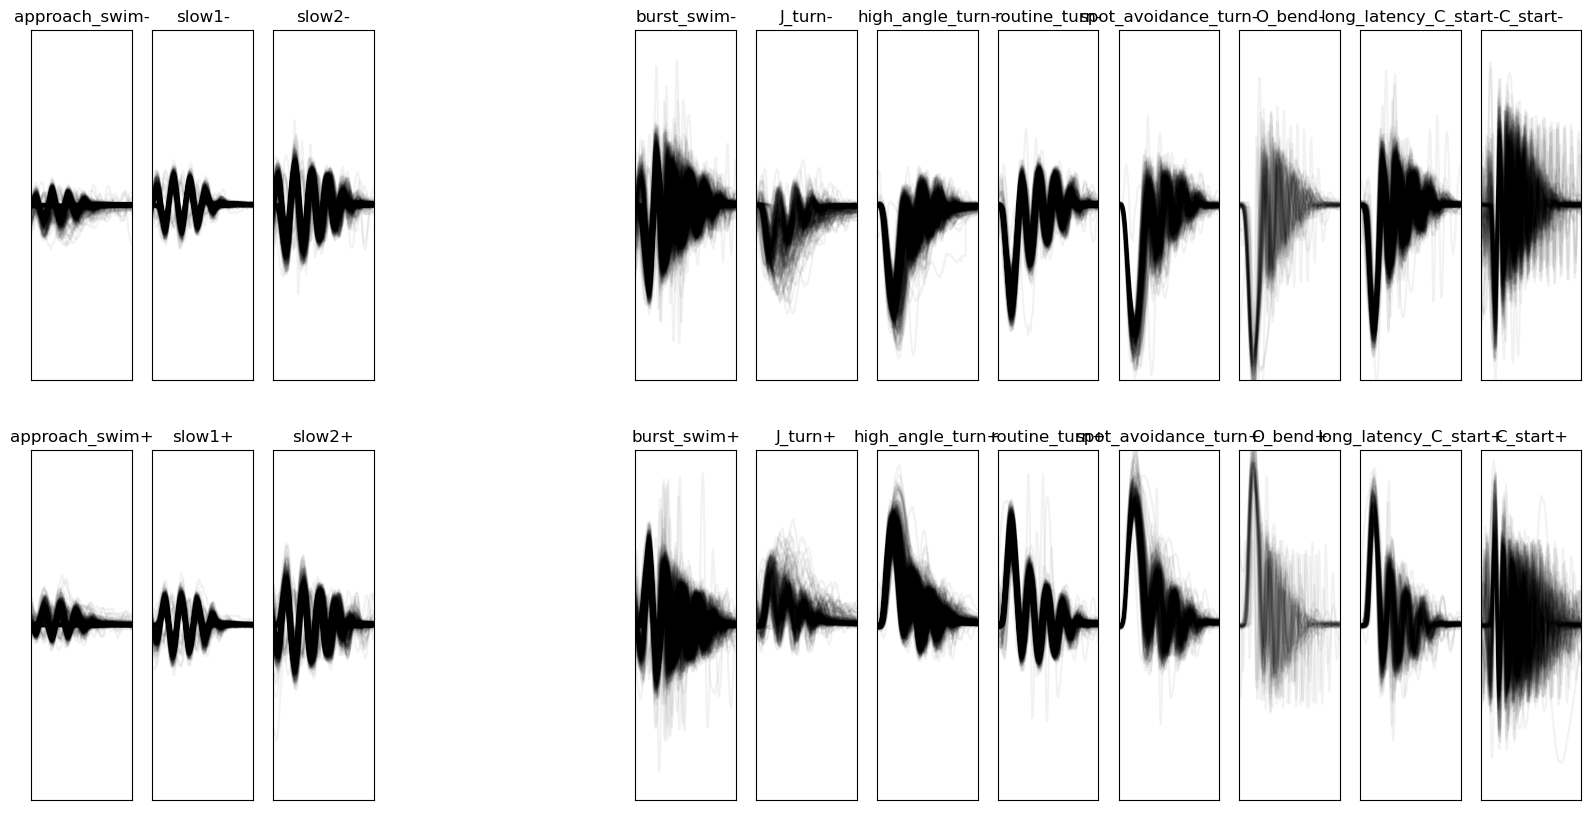

In [13]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    id = np.where(bout_category==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(tail_and_traj_array[id,6,:].T,'k',alpha=0.05)

    ax0.set_xlim(0,cfg_segment_classify.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Display example results

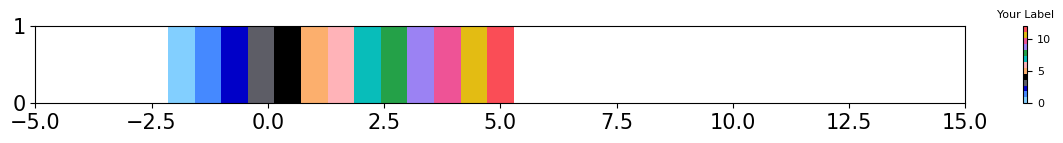

In [27]:
from megabouts.utils.utils_plot import NameCatSym_w_CS,list_color_w_CS,cmp_bouts
plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,30)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [28]:
segments = res.segments
id_nearest_template = res.classification.id_nearest_template_aligned

In [29]:
fps = cfg_tail_preprocess.fps
Duration = fps*7
IdSt = np.random.randint(tail_angle.shape[0]-Duration)
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)

sub_onset,sub_offset,sub_i= [],[],[]
for i,(on_,off_) in enumerate(zip(segments.onset,segments.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)
sub_i = np.array(sub_i)
sub_onset = np.array(sub_onset)
sub_offset = np.array(sub_offset)

sub_tail_array = tail_and_traj_array[sub_i,:7,:]
id = id_nearest_template[sub_i]
tail_nearest = pipeline.knn_training_dataset_augmented.tail[id,:,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

(-3.6, 3.6)

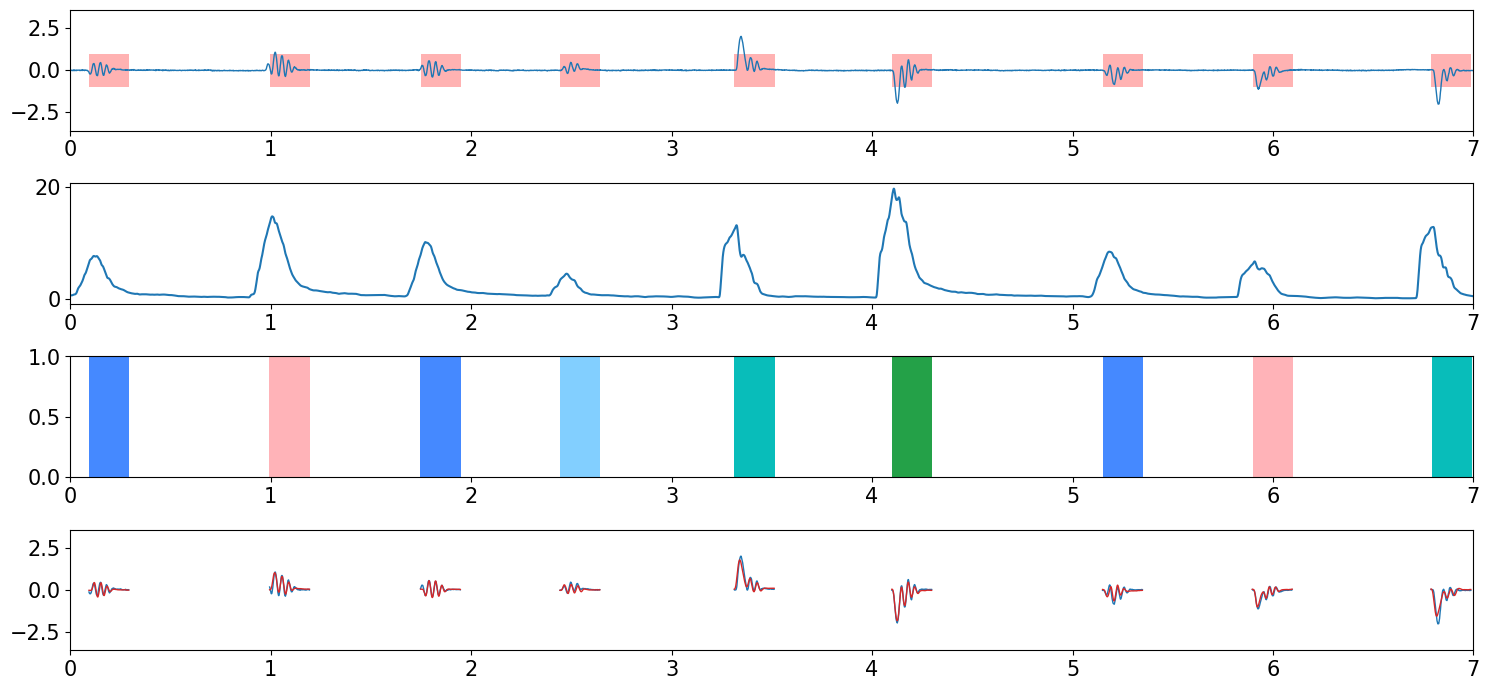

In [30]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(4,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)

ax = plt.subplot(G[1])
ax.plot(t,mobility[IdSt:IdEd])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[2])
ax.imshow(res.bout_category_ts[IdSt:IdEd,np.newaxis].T,
          cmap=cmp_bouts,
          aspect='auto',
          vmin=0,vmax=12,
          interpolation='nearest',extent=[0,Duration/fps,0,1])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[3])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    #ax.plot((np.arange(on_,off_))/fps,tail_angle_detrend[on_+IdSt:off_+IdSt,-1],'tab:blue')
    ax.plot((np.arange(on_,off_))/fps,sub_tail_array[i,-1,:],'tab:blue',lw=1)
    #off_ = on_+140
    ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)


(0.0, 7.0)

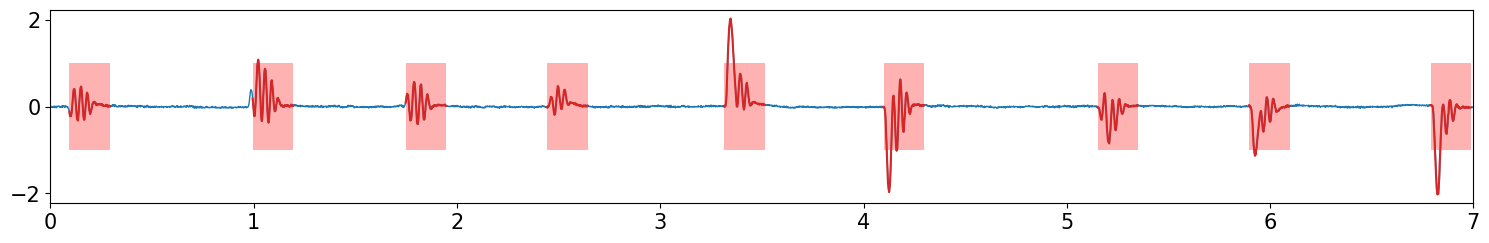

In [31]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(3,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[0])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_))/fps,res.tracking_data_clean.tail_angle[on_+IdSt:off_+IdSt,6],'tab:red')
    off_ = on_+140
#ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)

# Check Agreement with Matlab

In [19]:
from megabouts.classification.benchmark_w_matlab import compute_bout_cat_matlab
from megabouts.super_resolution.downsampling import create_downsampling_function
from megabouts.utils.utils import find_onset_offset_numpy
from megabouts.utils.utils_bouts import compute_bout_cat_ts
from scipy import stats

In [20]:
bout_cat_matlab = df.bout_sign_matlab.values
bout_cat_matlab[df.tail_active.values==0]=-1

bout_cat_unsigned = bout_category
bout_cat_unsigned[bout_cat_unsigned>-1]=bout_cat_unsigned[bout_cat_unsigned>-1]%13

In [21]:

onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df)

label_mat = []
label_py = []
for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = res.bout_category_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        label_py.append(stats.mode(tmp)[0][0])


C:\Users\adrien\AppData\Local\Temp\ipykernel_17636\310708994.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label_py.append(stats.mode(tmp)[0][0])


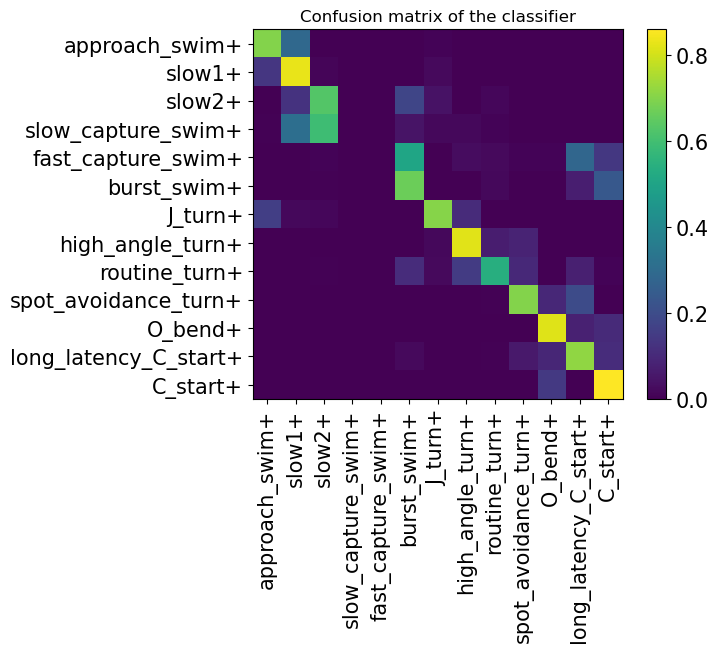

In [22]:
from sklearn.metrics import confusion_matrix
x = np.array(label_mat)
y = np.array(label_py)

cm = confusion_matrix(x, y, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [23]:
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

In [24]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

0.5868622095001832

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

0.6794681267109894

In [26]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)

0.7251764313746906

In [ ]:
0.70 margin_before_peak_ms=32,augment_max_delay_ms=24,augment_step_delay_ms=2,N_kNN=3,filename_template='TemplateFromkNN_Tu.npz'
0.72 margin_before_peak_ms=32,augment_max_delay_ms=24,augment_step_delay_ms=2,N_kNN=3,filename_template='kNN_Training_Dataset.npz'

In [ ]:
0.73 knn = 3 kNN_Training_Dataset
0.726 knn = 3 kNN_Training_Dataset margin_before_peak_ms=32,bout_duration_ms=200,augment_max_delay_ms=24, distance Weighted KNN


0.70 knn = 3 TemplateFromkNN_Tu

In [ ]:
0.7110439583131611 knn=3

# Display Time Series

# Plotly Save

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [35]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale


In [36]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)


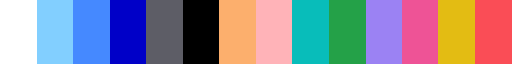

In [37]:
cmp_bouts

In [41]:
img.shape,np.unique(img)

((1, 40),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29]))

In [35]:
import plotly.express as px
import numpy as np

img = np.arange(-10,30).reshape(1,-1)
fig = px.imshow(img,color_continuous_scale=cmp_bouts,zmin=-1,zmax=13)

#fig.write_html("free_swimming_pipeline.html")

[autoreload of preprocessing.preprocessing failed: Traceback (most recent call last):
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class_

NameError: name 'cmp_bouts' is not defined

In [38]:
s = 7
onset,offset = segments.onset,segments.offset
x = tail_angle_clean[:,s][:,np.newaxis]
y = np.zeros_like(x)
for on_,off_ in zip(onset,offset):
    y[on_:off_]=1
t = np.arange(len(x))[:,np.newaxis]

print(x.shape,y.shape,t.shape,z.shape)
df=pd.DataFrame(np.hstack((t,x,y,z)), columns=['t','tail','tail_active','code1','code2','code3'])
id_st = 700*60*0
id_ed = 700*60*20
df = df.iloc[id_st:id_ed]
sub_onset,sub_offset=[],[]

for on_,off_ in zip(onset,offset):
    if (on_>id_st)&(off_<id_ed):
        sub_onset.append(on_)
        sub_offset.append(off_)

(8908250, 1) (8908250, 1) (8908250, 1) (8908250, 3)


In [39]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x=df['t'], y=df['tail'],mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['tail_active'],mode='lines'),
              row=1, col=1)


for i,(on_,off_) in enumerate(zip(sub_onset[:200],sub_offset[:200])):
    if i%2==0:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#EDAE49',opacity=0.3,layer="below")
    else:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#D1495B',opacity=0.3,layer="below")

#fig.add_trace(go.Scatter(x=peaks, y=np.ones(len(peaks)),mode='markers'),
#              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['code1'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code2'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code3'],mode='lines'),
              row=2, col=1)   

#fig['layout']['yaxis2'].update(title='', range=[0, 40], dtick=10, autorange=False)
#fig['layout']['yaxis1'].update(title='', range=[-3,3], dtick=10, autorange=False)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("free_swimming_pipeline.html")


NameError: name 'make_subplots' is not defined

# Illustration of sparse coding

[0 1 2]


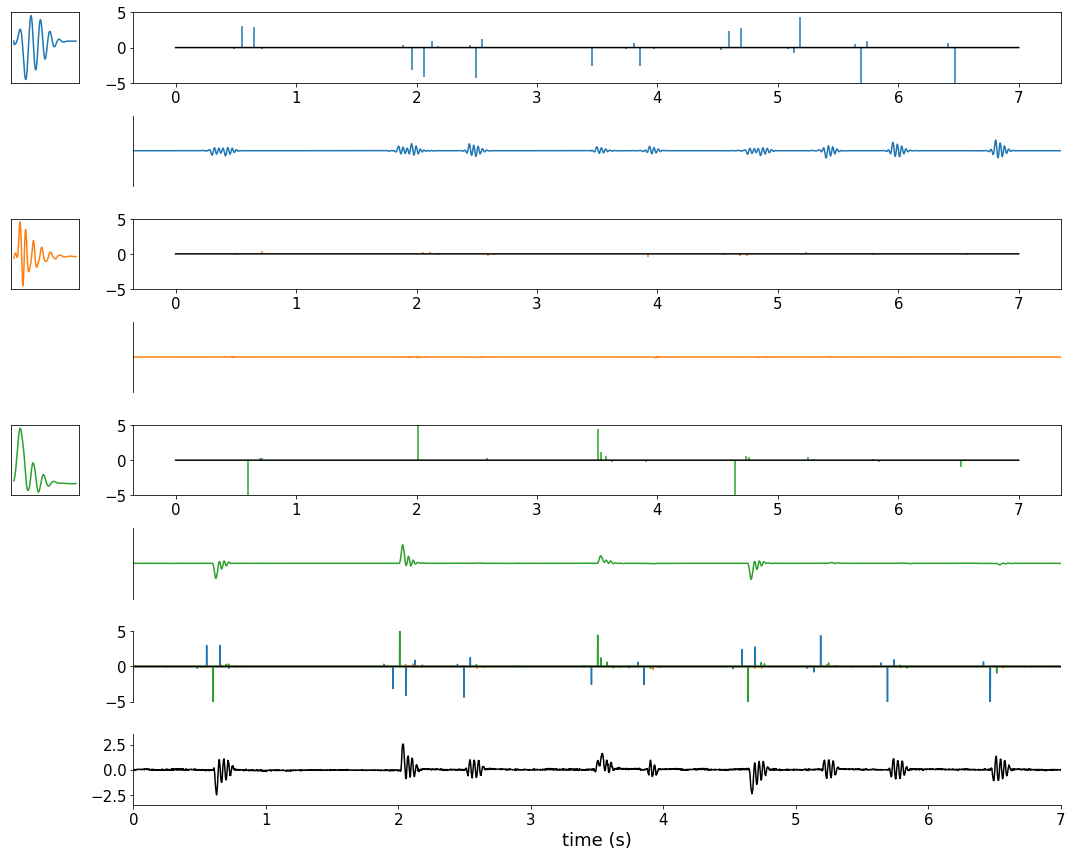

In [45]:
code = np.copy(z)
t = np.arange(0,Duration)/700
id_atom = np.where(np.sum(np.abs(code[IdSt:IdEd,:]),axis=0)>5)[0]

#id_atom = [i for i in ordered_atom if np.any(np.isin(id_atom,i))]
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(facecolor='white',figsize=(15,12),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(2*N+2,9)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle[IdSt:IdEd,7],'k')
ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,code[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_ylim(-5,5)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
k=0
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[k,1:])
    ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
    y = code[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]

    if len(x)>0:
        markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
        baseline.remove()
        markerline[i].remove()
        #plt.setp(markerline[i], color=cmaplist[i]) 
        plt.setp(stemline[i], color=cmaplist[i])
    ax.set_ylim(-5,5)

    
    ax = plt.subplot(G[k+1,1:])
    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
        
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[k:k+1,0])
    ax.plot(Dict[:,-1,i_code],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])

    k=k+2


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()